<a href="https://colab.research.google.com/github/vin136/sample-test/blob/master/mine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/vin136/sample-test.git

fatal: destination path 'sample-test' already exists and is not an empty directory.


In [10]:
import sys
!{sys.executable} -m pip install folium scikit-plot plotly xgboost graphviz

In [11]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

In [72]:
loc = '/content/sample-test/train.csv'
data =pd.read_csv(loc)

In [190]:

def basic_analysis(df):
  missing_vals_cnt = df.isna().sum().sum()
  cols = df.columns
  dtypes = df.dtypes
  uniq_vals = df.nunique()
  mis_cnt = df.isna().sum()
  print(f"Data shape: {df.shape[0]},{df.shape[-1]}")
  print(f"Missing vals cnt: {missing_vals_cnt}")
  summary = {"Column Name":[],"Data Type":[], "#Distinct":[],  "Missing Vals":[]}
  for i in range(len(df.columns)):
    summary['Column Name'].append(cols[i])
    summary['Data Type'].append(dtypes[i])
    summary['#Distinct'].append(uniq_vals[i])
    summary['Missing Vals'].append(mis_cnt[i])
  print(pd.DataFrame(summary))
    
basic_analysis(data)

Data shape: 2870,12
Missing vals cnt: 676
            Column Name Data Type  #Distinct  Missing Vals
0                    id     int64       2870             0
1                region    object          5             0
2              latitude   float64       2647             0
3             longitude   float64       2550             0
4    accommodation_type    object          3             0
5                  cost     int64        330             0
6        minimum_nights     int64         53             0
7     number_of_reviews     int64        160             0
8     reviews_per_month   float64        419           676
9              owner_id     int64       2371             0
10         owned_hotels     int64         40             0
11  yearly_availability     int64          2             0


### Types of variables

In [180]:
data.dtypes
# There are categorical and numerical variables

id                       int64
region                  object
latitude               float64
longitude              float64
accommodation_type      object
cost                     int64
minimum_nights           int64
number_of_reviews        int64
reviews_per_month      float64
owner_id                 int64
owned_hotels             int64
yearly_availability      int64
dtype: object

In [182]:
# let's inspect the variable values

for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

id [13232   246 19091 34305   444 30553 30500 48755  3647  2673 47512 39794
 22760 39743 36514 45327 37393 36840 20351 27292] 

region ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island'] 

latitude [40.71854 40.64446 40.78573 40.73863 40.82426 40.73976 40.67913 40.75288
 40.71735 40.76781 40.63293 40.68873 40.72948 40.72886 40.87072 40.72757
 40.7662  40.75985 40.73613 40.7237 ] 

longitude [-74.00439 -73.9503  -73.81062 -73.98002 -73.9463  -74.00953 -73.98015
 -73.97269 -73.99095 -73.92684 -73.97117 -73.96133 -74.00961 -73.99139
 -73.89974 -73.98336 -73.94676 -73.99799 -74.00711 -73.99454] 

accommodation_type ['Entire home/apt' 'Private room' 'Shared room'] 

cost [170  65  85 210  75 200  95 380  79  70  86 100 195 179 150 250 220  60
 199 130] 

minimum_nights [  5   3   1  30  10  20   2  31  12  28   4 360 180   7  60  90  29   6
  32 186] 

number_of_reviews [  7 238   0  38  11   8 259  75   1   2 113   6  16  22   4  65  20   9
   5   3] 

reviews_per_month [0.56 2.3   n

In [193]:
# make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='yearly_availability' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='yearly_availability' and var not in discrete]

mixed = []
# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var not in mixed]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))


There are 0 discrete variables
There are 9 continuous variables
There are 2 categorical variables


# Variable charecterization

In [195]:
categorical

['region', 'accommodation_type']

In [198]:
continuous

['id',
 'latitude',
 'longitude',
 'cost',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'owner_id',
 'owned_hotels']

`OBSERVATION`: owner_id has almost the equal cardinality of the #rows, nor is it an ordinal value. Thus this column will not be included in the analysis.

#### Exploring distributions of input

Note: The objective of eda here is to give insights about modeling,not just to show nice visualizations.

In [176]:
%matplotlib inline
import scipy.stats as stats


#objective: identify the distribution of the variable and detect outliers
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

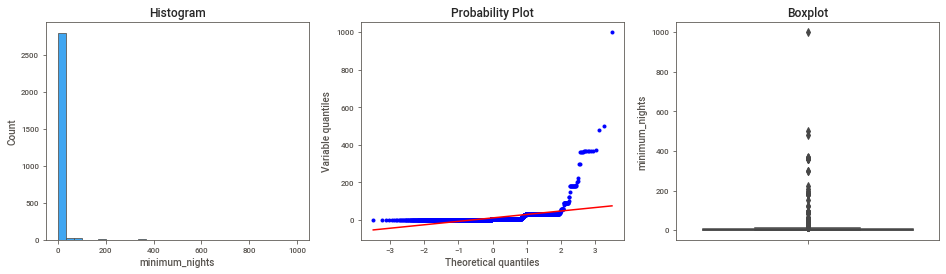

In [177]:
# colums of interest = cost ,minimum_nights ,number_of_reviews ,reviews_per_month   
diagnostic_plots(data,'minimum_nights')                            

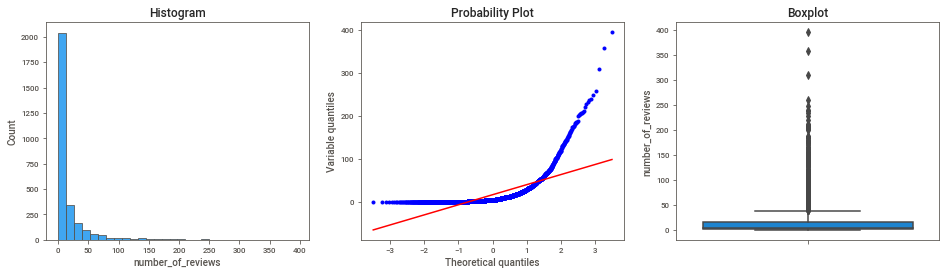

In [178]:
diagnostic_plots(data,'number_of_reviews')                            

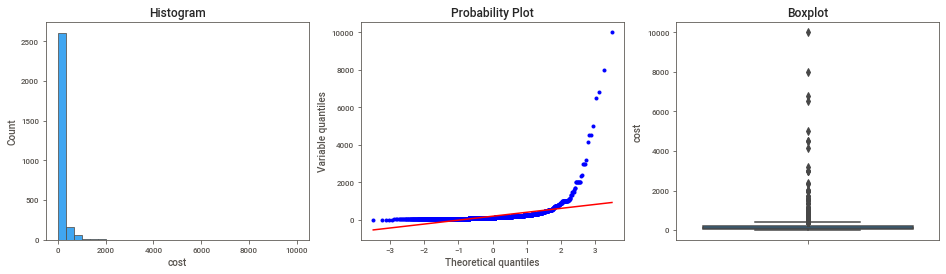

In [179]:
diagnostic_plots(data,'cost')                            

`obs`: extreme outliers or heavy tailed distribution(not necessarily a bad thing). From modeling standpoint, any standardisation (min-max,mean etc) will squeeze the range unnecessarily if done without capping/other outlier handling methods. Thus my first choice is to try with  scale and distribution agnostic algorithms like - **Decision trees or boosted trees**

In [208]:
data['reviews_per_month'].min(),data['reviews_per_month'].max()

(0.01, 10.37)

### Categorical variables

Is there high cardinality?

High cardinality poses the following challenges: 

- Variables with too many labels tend to dominate those with only a few labels, particularly in **decision tree-based** algorithms.

- High cardinality may introduce noise.

**Algorithms based on decision trees can be biased towards variables with high cardinality**.

Thus I choose to drop `id`,`owner_id`.


Categories to study: `accommodation_type`,`region `

In [205]:
data[['region','yearly_availability']].groupby('region').describe()

yearly_availability                                             
                            count      mean       std  min  25%  50%  75%  max
region                                                                        
Bronx                        78.0  0.730769  0.446431  0.0  0.0  1.0  1.0  1.0
Brooklyn                   1075.0  0.447442  0.497461  0.0  0.0  0.0  1.0  1.0
Manhattan                  1333.0  0.488372  0.500052  0.0  0.0  0.0  1.0  1.0
Queens                      370.0  0.621622  0.485639  0.0  0.0  1.0  1.0  1.0
Staten Island                14.0  0.857143  0.363137  0.0  1.0  1.0  1.0  1.0

In [206]:
data[['accommodation_type','yearly_availability']].groupby('accommodation_type').describe()

yearly_availability                                     \
                                 count      mean       std  min  25%  50%   
accommodation_type                                                          
Entire home/apt                 1002.0  0.057884  0.233641  0.0  0.0  0.0   
Private room                    1225.0  0.898776  0.301749  0.0  1.0  1.0   
Shared room                      643.0  0.423017  0.494423  0.0  0.0  0.0   

                              
                    75%  max  
accommodation_type            
Entire home/apt     0.0  1.0  
Private room        1.0  1.0  
Shared room         1.0  1.0

## missing variables

Ideally missingness should be further investigated. (MCAR,MAR,MNAR)

In [93]:
#smell testing if missingness is at random or does missingness have any strong predictive power 
is_missing = data[['reviews_per_month']].isna()['reviews_per_month']
avg_missing = data[is_missing]['yearly_availability'].mean()
avg_notmissing = data[~is_missing]['yearly_availability'].mean()
print(f'avg availability for missing reviews:{avg_missing},non-missing:{avg_notmissing}')


avg availability for missing reviews:0.7633136094674556,non-missing:0.4170464904284412


Since the data-set size is low and also initial smell test suggests possible predictive power, I choose to encode the missingness in the training pipeline. I would find the best imputation technique.



In [106]:
percent_missing = is_missing.sum()*100/len(is_missing)
percent_missing # this is a big number,thus it matters how we choose to impute as any method(mean,median etc)
#will drastically alter the distribution

23.554006968641115

In [138]:
# import classes for imputation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# import extra classes for modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)

In [209]:
#owner_id,id are removed.

X = data[['region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month','owned_hotels']]
Y = data['yearly_availability']


# find categorical variables
# those of type 'Object' in the dataset
features_categorical = [c for c in X.columns if X[c].dtypes=='O']

# find numerical variables
# those different from object and also excluding the target SalePrice
features_numerical = [c for c in X.columns if X[c].dtypes!='O' and c !='yearly_availability']




#scaling never hurts
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#just to safegaurd, imputation is added here too
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, features_numerical),
        ('categorical', categorical_transformer, features_categorical)])

#here constant = 0,find best imputation strategy
param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median','constant']
}





In [210]:
X.shape,Y.shape

((2870, 9), (2870,))

In [211]:
from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0, n_estimators = 10)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', rfc)])

grid_search = GridSearchCV(clf, param_grid, cv=5,n_jobs=-1, scoring='accuracy')



In [212]:
grid_search.fit(X,Y.values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'cost',
                                                                          'minimum_nights',
                                                       

In [213]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'cost', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'owned_hotels']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                

In [214]:
print(("best random forest fit from grid search: %.3f"
       % grid_search.score(X, Y)))

# Note that this is cross-val score,this gives a reasonable estimate for generalization performance

best random forest fit from grid search: 0.995


Here we see that simple imputation with `constant` gives best score. 

In [215]:
# for completeness I'll also do the same with logistic regression

from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', logisticRegr)])

grid_search_lr = GridSearchCV(clf_lr, param_grid, cv=5,n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X,Y.values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'cost',
                                                                          'minimum_nights',
                                                       

In [216]:
grid_search_lr.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'cost', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'owned_hotels']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                  

In [217]:
print(("best random forest fit from grid search: %.3f"
       % grid_search_lr.score(X, Y)))


best random forest fit from grid search: 0.872


Here median comes out to be the best imputer.(this also matches my intuition). Thus I'll fix the above imputation methods for respective classifiers.

In [218]:
#encoder = OneHotEncoder(categories='auto',
                      # drop='first', # to return k-1, use drop=false to return k dummies
                      # sparse=False,
                      # handle_unknown='error') # helps deal with rare labels



In [221]:
# view percentage of frequency distribution of label
data['yearly_availability'].value_counts()/len(data)
# Thus,we have balanced classification

0    0.501394
1    0.498606
Name: yearly_availability, dtype: float64

## Modeling

In [261]:
# model-classes : Logistic regression, RF's , Gradient Boosting trees.

input_cols = ['region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month','owned_hotels']

X = data[input_cols]
Y = data['yearly_availability']

features_categorical = [c for c in X.columns if X[c].dtypes=='O']

# find numerical variables
# those different from object and also excluding the target SalePrice
features_numerical = [c for c in X.columns if X[c].dtypes!='O' and c !='yearly_availability']

# create k-dummies
encoder_red = OneHotEncoder(categories='auto',
                       drop=None, 
                       sparse=False,
                       handle_unknown='error') # helps deal with rare labels
#create k-1 dummies
encoder = OneHotEncoder(categories='auto',
                       drop='first', # to return k-1, use drop=false to return k dummies
                       sparse=False,
                       handle_unknown='error') # helps deal with rare labels


#scaling never hurts
numeric_transformer_median = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#impute with a out-dist value of -1
numeric_transformer_constant = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value=-1)),
    ('scaler', StandardScaler())])



#just to safegaurd, imputation is added here too->one-hot with redundancy
categorical_transformer_trees = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', encoder_red)])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', encoder)])





tree_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer_constant, features_numerical),
        ('categorical', categorical_transformer_trees, features_categorical)])

regression_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer_median, features_numerical),
        ('categorical', categorical_transformer, features_categorical)])





In [250]:
out = tree_preprocessor.fit_transform(X)
out.shape

(2870, 15)

In [242]:
tree_preprocessor.transformers_[1][1]['onehot'].get_feature_names()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_Bronx', 'x0_Brooklyn', 'x0_Manhattan', 'x0_Queens',
       'x0_Staten Island', 'x1_Entire home/apt', 'x1_Private room',
       'x1_Shared room'], dtype=object)

In [248]:
tree_preprocessor.transformers_[0]

('numerical',
 Pipeline(steps=[('imputer', SimpleImputer(fill_value=-1, strategy='constant')),
                 ('scaler', StandardScaler())]),
 ['latitude',
  'longitude',
  'cost',
  'minimum_nights',
  'number_of_reviews',
  'reviews_per_month',
  'owned_hotels'])

In [251]:
cols = ['latitude',
  'longitude',
  'cost',
  'minimum_nights',
  'number_of_reviews',
  'reviews_per_month',
  'owned_hotels','x0_Bronx', 'x0_Brooklyn', 'x0_Manhattan', 'x0_Queens',
       'x0_Staten Island', 'x1_Entire home/apt', 'x1_Private room',
       'x1_Shared room']

In [252]:
len(cols)

15

In [253]:
pd.DataFrame(out,columns=cols)

,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owned_hotels,x0_Bronx,x0_Brooklyn,x0_Manhattan,x0_Queens,x0_Staten Island,x1_Entire home/apt,x1_Private room,x1_Shared room
0,-0.230897,-1.090408,-0.063882,-0.172006,-0.286837,-0.059667,-0.273479,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-1.579468,-0.002863,-0.322430,-0.224685,6.826094,1.102625,-0.273479,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.992246,2.805573,-0.273182,-0.277364,-0.502380,-1.101722,-0.273479,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.134826,-0.600420,0.034613,0.486483,-0.502380,-1.101722,2.088075,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.693655,0.077562,-0.297806,-0.224685,0.667712,-0.153185,-0.199680,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,0.217291,-0.607658,0.502462,-0.251024,-0.502380,-1.101722,-0.273479,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2866,0.072932,-0.894574,-0.039258,-0.224685,-0.440796,-0.386979,-0.273479,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2867,0.636535,-0.798466,-0.041720,-0.224685,0.021082,0.013811,-0.273479,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2868,0.275727,-0.440575,0.009989,0.486483,-0.502380,-1.101722,1.497687,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [267]:
# rfmodel
#`PIPELINING`: Good practice to avoid data leakage and reproducability.

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

#'preprocessor__numerical__imputer__strategy'
random_grid = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}



rfc = RandomForestClassifier(random_state=0, n_estimators = 50)
rf_model = Pipeline(steps=[('preprocessor', tree_preprocessor),
                      ('model', rfc)])

# do rand search first to find decent params space
rand_search = RandomizedSearchCV(rf_model, random_grid,n_iter=50,verbose=2, cv=3,n_jobs=-1, scoring='accuracy')




In [268]:
rand_search.fit(X,Y.values)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['latitude',
                                                                                'longitude',
                                                

In [270]:
rand_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'cost', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'owned_hotels']),
                                                 ('categorical',
                              

In [272]:

print(("best random forest fit from grid search: %.3f"
       % rand_search.score(X, Y.values)))


best random forest fit from grid search: 0.975


In [278]:
rfc = RandomForestClassifier(random_state=0, n_estimators = 1281,min_samples_split=10,min_samples_leaf=2,bootstrap=False)
rf_model = Pipeline(steps=[('preprocessor', tree_preprocessor),
                      ('model', rfc)])

rf_model.fit(X,Y.values)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'cost', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'owned_hotels']),
                                                 ('categorical',
                              

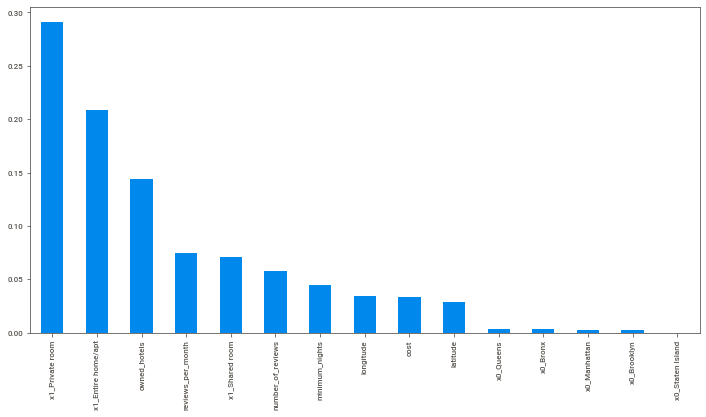

In [279]:
importance = pd.Series(rf_model.named_steps['model'].feature_importances_)
importance.index = cols
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

In [285]:
import scipy
from scipy.cluster import hierarchy as hc
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
    


In [286]:
out = pd.DataFrame(out,columns=cols)

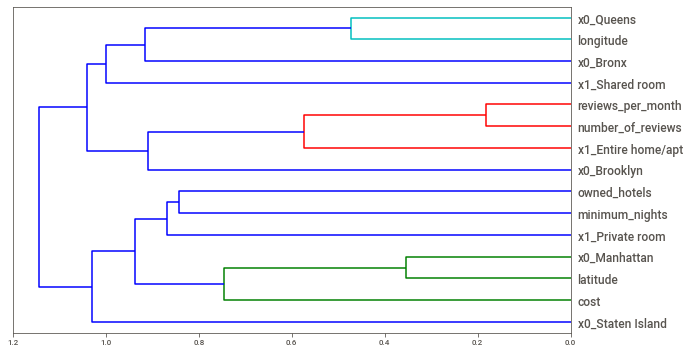

In [287]:
cluster_columns(out)

In [288]:
importance

x1_Private room       0.291030
x1_Entire home/apt    0.208944
owned_hotels          0.144436
reviews_per_month     0.074834
x1_Shared room        0.070565
number_of_reviews     0.057641
minimum_nights        0.044800
longitude             0.034499
cost                  0.033525
latitude              0.028303
x0_Queens             0.003598
x0_Bronx              0.002978
x0_Manhattan          0.002731
x0_Brooklyn           0.002059
x0_Staten Island      0.000057
dtype: float64